In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from string import punctuation
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
!pip install pyspellchecker


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [0]:
df = pd.read_csv("/content/drive/My Drive/GA-hackathon/Sentiment Analysis/train.csv")


In [0]:
df_test = pd.read_csv("/content/drive/My Drive/GA-hackathon/Sentiment Analysis/test.csv")

In [120]:
df.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


Text(0, 0.5, 'frequency')

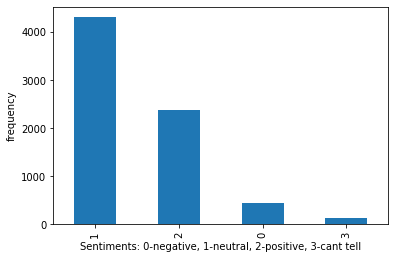

In [121]:
df["sentiment"].value_counts().plot(kind="bar")
plt.xlabel("Sentiments: 0-negative, 1-neutral, 2-positive, 3-cant tell")
plt.ylabel("frequency")

Sentiment 3 doesnt give information about emotions of user. So dropping those sentiments

In [0]:
df = df.drop(df[df["sentiment"]==3].index)

In [123]:
df.shape

(7149, 3)

Text(0, 0.5, 'frequency')

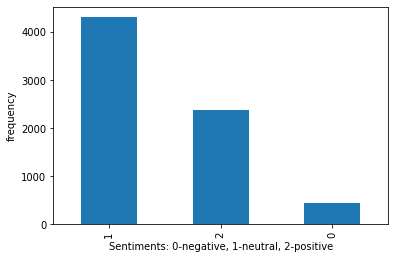

In [124]:
df["sentiment"].value_counts().plot(kind="bar")
plt.xlabel("Sentiments: 0-negative, 1-neutral, 2-positive")
plt.ylabel("frequency")

In [0]:
""" function to clean the tweet """
def clean_tweet(text):
    text = str(text).lower()
    soup = BeautifulSoup(str(text), "lxml")
    soup_text = soup.get_text() 

    link_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', soup_text)
    link_text = re.sub(r'@[\w]*', '', soup_text)
    link_text = re.sub("{link}", " ", link_text)
    link_text = re.sub("rt", " ", link_text)
    # link_text = re.sub("sxsw", " ", link_text)
    try:
        clean = link_text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = link_text
    letters_only = re.sub("[^#a-zA-Z]", " ", clean)
    return letters_only
    
    

In [0]:
total_df1 = pd.concat([ df["tweet"], df_test["tweet"]], 0)
total_df = pd.DataFrame(total_df1, columns=["tweet"])

### Replacing Sentiments with words


In [0]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# SadEmoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

def check_emoticon(txt):
  all_text=[]
  txt1 = str(txt).split()
  for t in txt1:
    for happy in emoticons_happy:
      if t == happy:
        all_text.append("happy")    
    for sad in emoticons_sad:
      if t == sad:
        all_text.append("sad")  
    else:
        all_text.append(txt1)

  result = ' '.join(all_text[0])

  return result

total_df.tweet = total_df.tweet.apply(lambda x: check_emoticon(x))


### Clean the tweets

In [0]:
total_df.tweet = total_df.tweet.apply(clean_tweet)

In [129]:
total_df.head()

,tweet
0,#sxswnui #sxsw #apple defining language of tou...
1,learning ab google doodles all doodles should...
2,one of the most in your face ex of stealing t...
3,this iphone #sxsw app would b pretty awesome i...
4,line outside the apple store in austin waiting...


### Tokenize and only consider the words which are not sxsw

In [0]:
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't"]

In [0]:
total_df.tweet = total_df.tweet.apply(lambda x: nltk.word_tokenize(x))

In [0]:
def char_len(text):

  total_text=[]
  for w in text:
    if len(w.strip())>2:
      if "sxsw" not in w:
        total_text.append(w)
  return total_text
    
total_df.tweet = total_df.tweet.apply(lambda x: char_len(x))


In [133]:
total_df.head()

,tweet
0,"[apple, defining, language, touch, with, diffe..."
1,"[learning, google, doodles, all, doodles, shou..."
2,"[one, the, most, your, face, stealing, the, sh..."
3,"[this, iphone, app, would, pretty, awesome, di..."
4,"[line, outside, the, apple, store, austin, wai..."


In [0]:
total_df.tweet = total_df.tweet.apply(lambda row: [word for word in row if word not in stop_words])

In [135]:
total_df.tweet.head()

0    [apple, defining, language, touch, different, ...
1    [learning, google, doodles, doodles, light, fu...
2    [one, face, stealing, show, yrs, apple, school...
3    [iphone, app, would, pretty, awesome, crash, e...
4    [line, outside, apple, store, austin, waiting,...
Name: tweet, dtype: object

In [0]:
#spell checking
# from spellchecker import SpellChecker

# def spell_corr(txt):
#   correct=[]
#   for w in txt:
#     spell = SpellChecker()
#     corr = spell.correction(w)
#     correct.append(w)
#   print(correct)

# total_df.tweet.head().apply(spell_corr)

In [0]:
total_df.tweet = total_df.tweet.apply(lambda x: ' '.join(x))

In [138]:
total_df.tweet.head()

0    apple defining language touch different dialec...
1    learning google doodles doodles light funny in...
2    one face stealing show yrs apple schools mkt expe
3    iphone app would pretty awesome crash every mi...
4     line outside apple store austin waiting new ipad
Name: tweet, dtype: object

### Lemmatize to base form

In [0]:
# lemmatizer = WordNetLemmatizer() 
# total_df.tweet = total_df.tweet.apply(lambda x: [lemmatizer.lemmatize(i, pos='v') for i in x] )


from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

# print(' '.join(lemmatize_all("i want better dogs")))

total_df.tweet = total_df.tweet.apply(lambda x: ' '.join(lemmatize_all(x)) )

In [140]:
total_df.tweet.head()

0    apple define language touch different dialect ...
1    learn google doodle doodle light funny innovat...
2        one face steal show yrs apple school mkt expe
3    iphone app would pretty awesome crash every mi...
4        line outside apple store austin wait new ipad
Name: tweet, dtype: object

In [0]:
# only consider the words which are in nltk

# words = set(nltk.corpus.words.words())

# def clean_sent(sent):
    
#     return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
#      if w.lower() in words or not w.isalpha())

# total_df.tweet = total_df.tweet.apply(clean_sent)

In [0]:
# total_df.tweet.head()

### WordCloud

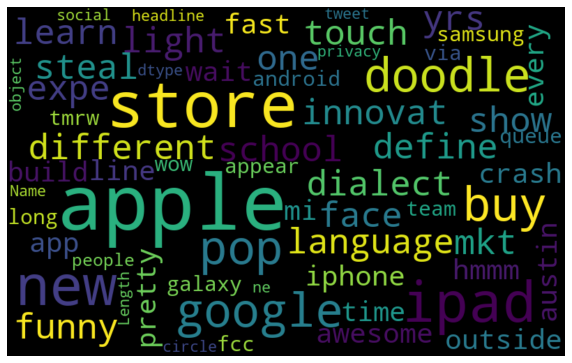

In [143]:
all_words = total_df.tweet

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [144]:
total_df.head()

,tweet
0,apple define language touch different dialect ...
1,learn google doodle doodle light funny innovat...
2,one face steal show yrs apple school mkt expe
3,iphone app would pretty awesome crash every mi...
4,line outside apple store austin wait new ipad


In [0]:
# def print_u(txt):
#   if "sad" in txt:
#     print(txt)

# total_df.tweet.apply(print_u)

Chat word replacement

In [0]:
chat_words_str = """AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The Ass
PRT=Party
PRW=Parents Are Watching
QPSA?=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My Ass Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The Fcuk
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick Laugher"""

# chat_words_str.split("\n")
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        cw_expanded = cw_expanded.lower()
        cw = cw.lower()
        chat_words_list.append(cw)
        
        chat_words_map_dict[cw] = cw_expanded

chat_words_list = set(chat_words_list)

# chat_words_map_dict
# chat_words_list

In [0]:
# chat_words_list

In [0]:
def chat_words_conversion(text):
  text = text.lower()
  new_text = []
  for w in text.split():

    if w.lower() in chat_words_list:
      new_text.append(chat_words_map_dict[w.lower()])
    else:
      new_text.append(w)
  return " ".join(new_text)

In [149]:
chat_words_conversion("one minute BRB")

'one minute be right back'

In [0]:
total_df.tweet = total_df.tweet.apply(chat_words_conversion)

In [151]:
total_df.tweet.head()

0    apple define language touch different dialect ...
1    learn google doodle doodle light funny innovat...
2        one face steal show yrs apple school mkt expe
3    iphone app would pretty awesome crash every mi...
4        line outside apple store austin wait new ipad
Name: tweet, dtype: object

In [0]:
#Common word removal
freq = pd.Series(' '.join(total_df.tweet).split()).value_counts()[:10]
# freq
freq1 = list(freq.index)
total_df.tweet = total_df.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in freq1))

In [0]:
freq_rare = pd.Series(' '.join(total_df.tweet).split()).value_counts()[-10:]
freq_rare1 = list(freq_rare.index)

total_df.tweet = total_df.tweet.apply(lambda x: " ".join(x for x in str(x).split() if x not in freq_rare1))

### Machine Learning Models

In [0]:
from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint 

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, f1_score

In [0]:
# from sklearn.metrics import plot_confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()




In [0]:
total_df.tweet.head()

0    apple define language touch different dialect ...
1    learn ab google doodle doodle light funny inno...
2     one face ex steal show yrs apple school mkt expe
3    iphone app would b pretty awesome crash every ...
4        line outside apple store austin wait new ipad
Name: tweet, dtype: object

In [0]:
df.shape, total_df.tweet.iloc[:7149].shape

((7149, 3), (7149,))

In [0]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(train_tfidf[:7149],df['sentiment'],test_size=0.3,random_state=1)

#### NOTE: SGDClassifier behaves as SVM when loss is hinge; it behaves as Logistic Regression when loss is log

### Logistic Regression

In [0]:
sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet',loss="log", random_state=1)
sgd.fit(X_train,y_train)

y_pred = sgd.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.17      0.27       147
           1       0.71      0.86      0.78      1308
           2       0.60      0.45      0.52       690

    accuracy                           0.68      2145
   macro avg       0.67      0.49      0.52      2145
weighted avg       0.67      0.68      0.66      2145



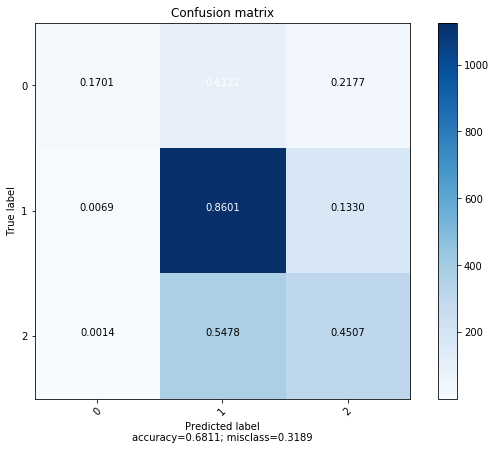

In [0]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[0,1,2])

In [0]:
y_pred_test = sgd.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_logreg_tts.csv",index=False)

### SGD/ SVM

In [0]:
sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet', random_state=1, loss="hinge")
sgd.fit(X_train,y_train)

y_pred = sgd.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.22      0.33       147
           1       0.71      0.84      0.77      1308
           2       0.60      0.48      0.53       690

    accuracy                           0.68      2145
   macro avg       0.67      0.51      0.54      2145
weighted avg       0.67      0.68      0.66      2145



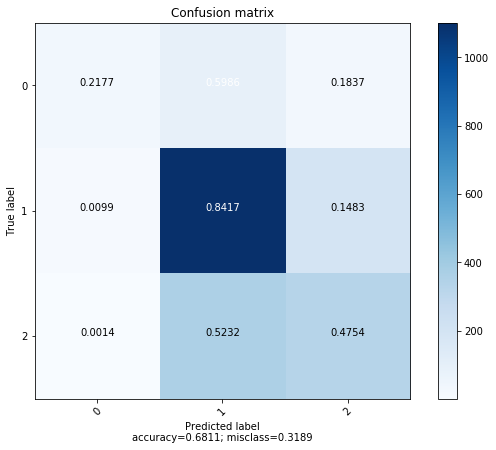

In [0]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[0,1,2])

In [0]:
y_pred_test = sgd.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_removed_dup86_tts.csv",index=False)

### NB

In [0]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1e-05)
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.29      0.37      0.33       147
           1       0.73      0.67      0.70      1308
           2       0.48      0.52      0.50       690

    accuracy                           0.60      2145
   macro avg       0.50      0.52      0.51      2145
weighted avg       0.62      0.60      0.61      2145



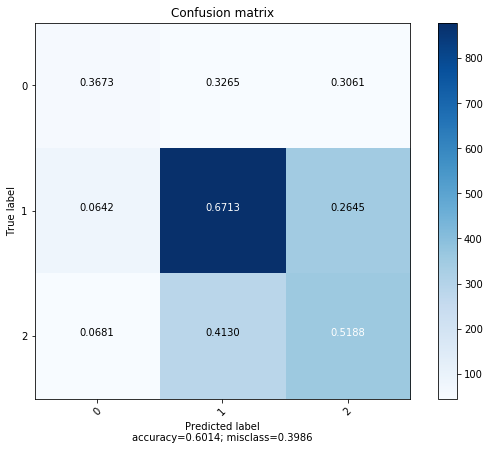

In [0]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[0,1,2])

In [0]:
y_pred_test = nb.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_nb_tts.csv",index=False)

### SVC

In [0]:
from sklearn.svm import SVC
svm = SVC(kernel='linear',gamma='scale',random_state=1)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.86      0.12      0.21       147
           1       0.69      0.90      0.78      1308
           2       0.64      0.38      0.48       690

    accuracy                           0.68      2145
   macro avg       0.73      0.47      0.49      2145
weighted avg       0.68      0.68      0.64      2145



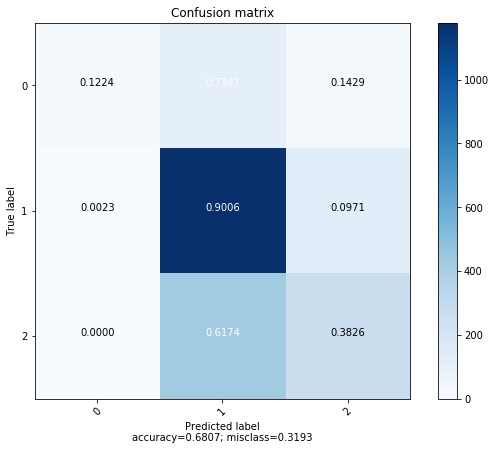

In [0]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[0,1,2])

In [0]:
# print(pd.Series(y_pred_test).value_counts())
y_pred_test = svm.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_svc_tts.csv",index=False)

### Random Forest

In [0]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.14      0.24       147
           1       0.67      0.91      0.77      1308
           2       0.64      0.31      0.41       690

    accuracy                           0.67      2145
   macro avg       0.69      0.45      0.48      2145
weighted avg       0.67      0.67      0.62      2145



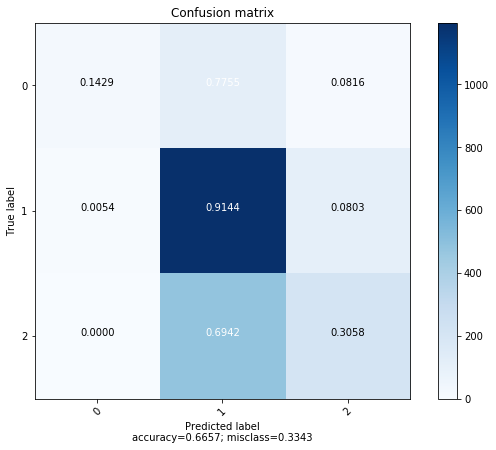

In [0]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[0,1,2])

In [0]:
# print(pd.Series(y_pred_test).value_counts())
y_pred_test = rf.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_rf_tts.csv",index=False)

### XGBoost

In [0]:
params = {'colsample': 0.9,
 'colsample_bytree': 0.9,
 'eta': 0.005,
 'max_depth': 9,
 'min_child_weight': 7,
 'num_class': 3,
 'objective': 'multi:softmax',
 'subsample': 0.9}

In [0]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train) 
dvalid = xgb.DMatrix(X_test, label=y_test) 
dtest = xgb.DMatrix(test_tfidf)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    return [('f1_score', f1_score(labels, preds, average='weighted'))]

In [0]:
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 3500,
    maximize=True,
    evals=[(dvalid, "Validation")]
 )

[0]	Validation-merror:0.365967	Validation-f1_score:0.572591
[1]	Validation-merror:0.367366	Validation-f1_score:0.565705
[2]	Validation-merror:0.3669	Validation-f1_score:0.562801


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[3]	Validation-merror:0.360839	Validation-f1_score:0.570767
[4]	Validation-merror:0.360373	Validation-f1_score:0.569203
[5]	Validation-merror:0.359441	Validation-f1_score:0.570634
[6]	Validation-merror:0.358042	Validation-f1_score:0.572479
[7]	Validation-merror:0.35711	Validation-f1_score:0.573851
[8]	Validation-merror:0.359441	Validation-f1_score:0.571795
[9]	Validation-merror:0.358974	Validation-f1_score:0.571317
[10]	Validation-merror:0.35711	Validation-f1_score:0.571649
[11]	Validation-merror:0.358974	Validation-f1_score:0.571064
[12]	Validation-merror:0.357576	Validation-f1_score:0.570989
[13]	Validation-merror:0.359441	Validation-f1_score:0.568525
[14]	Validation-merror:0.359441	Validation-f1_score:0.56963
[15]	Validation-merror:0.358974	Validation-f1_score:0.569143
[16]	Validation-merror:0.363636	Validation-f1_score:0.56465
[17]	Validation-merror:0.362704	Validation-f1_score:0.565672
[18]	Validation-merror:0.361305	Validation-f1_score:0.566738
[19]	Validation-merror:0.363636	Val

In [0]:
y_pred = xgb_model.predict(dvalid) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.11      0.18       147
           1       0.69      0.85      0.76      1308
           2       0.58      0.41      0.48       690

    accuracy                           0.66      2145
   macro avg       0.62      0.46      0.48      2145
weighted avg       0.65      0.66      0.63      2145



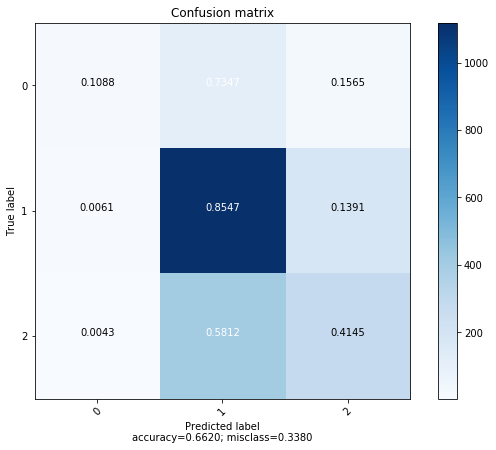

In [0]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[0,1,2])

In [0]:
submit_id=list(df_test["tweet_id"])

test_pred = xgb_model.predict(dtest) 
submit_pred=list(test_pred)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_xgb_finetune1500.csv",index=False)

### Grid Search - SGD

In [0]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol=1e-3, loss="hinge")),
    # ('xg', XGBClassifier(random_state=42))
])

In [0]:
parameters = {
    'vect__max_df': (0.55,0.67),
    # 'vect__min_df': (0.1,0.2),
    # 'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1,2),(1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__random_state':(1,42),
    # 'clf__max_iter': (20,10,80),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2','l1', 'elasticnet'),
    'clf__max_iter': (50, 1000),
}


In [0]:
grid_search = GridSearchCV(pipeline, parameters, scoring="f1_weighted",cv=5,
                               n_jobs=-1, verbose=1)

In [0]:
# total_df.tweet.iloc[:7274]

total_df.tweet.iloc[:7149]

0       apple define language touch different dialect ...
1       learn ab google doodle doodle light funny inno...
2        one face ex steal show yrs apple school mkt expe
3       iphone app would b pretty awesome crash every ...
4           line outside apple store austin wait new ipad
                              ...                        
7269    google plze tammi middle craziness everything ...
7270                      set edchat musedchat newtwitter
7271    aha find proof lactation room excuse mother ro...
7272        launch ipad app get detail first edition free
7273    next fin serv battle v apple goog mobile opera...
Name: tweet, Length: 7149, dtype: object

In [0]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
# grid_search.fit(total_df.tweet.iloc[:7274], df["sentiment"])
grid_search.fit(total_df.tweet.iloc[:7149], df["sentiment"])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):

  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (50, 1000),
 'clf__penalty': ('l2', 'l1', 'elasticnet'),
 'clf__random_state': (1, 42),
 'vect__max_df': (0.55, 0.67),
 'vect__ngram_range': ((1, 2), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.2min finished


done in 131.190s

Best score: 0.678
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 50
	clf__penalty: 'elasticnet'
	clf__random_state: 1
	vect__max_df: 0.55
	vect__ngram_range: (1, 2)


In [0]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

### SVM F1- 68

In [0]:
vec = CountVectorizer(max_df=0.55,ngram_range= (1,2))

train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7149])
test_df_vec = vec.transform(total_df.tweet.iloc[7149:])



tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)

sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet', random_state=1)
sgd.fit(train_tfidf, df["sentiment"])

y_pred_test = sgd.predict(test_tfidf)

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_removed_sxsw_itr50_.csv",index=False)



In [0]:
total_df.tweet.head() # strings containing sxsw has been removed completely

0    apple define language touch different dialect ...
1    learn ab google doodle doodle light funny inno...
2     one face ex steal show yrs apple school mkt expe
3    iphone app would b pretty awesome crash every ...
4        line outside apple store austin wait new ipad
Name: tweet, dtype: object

In [0]:
#f1 duplicate 68.15 -- SGD as SVM

vec = CountVectorizer(max_df=0.55,ngram_range= (1,2))

train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7149])
test_df_vec = vec.transform(total_df.tweet.iloc[7149:])



tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)

sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet',loss="hinge", random_state=1)
sgd.fit(train_tfidf, df["sentiment"])

y_pred_test = sgd.predict(test_tfidf)

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_svm_removed_sxsw_dup68_.csv",index=False)

In [0]:
#SGD - Log reg - 68.04

vec = CountVectorizer(max_df=0.55,ngram_range= (1,2))

train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7149])
test_df_vec = vec.transform(total_df.tweet.iloc[7149:])



tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)

sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='l1', random_state=1, loss="log")
sgd.fit(train_tfidf, df["sentiment"])

y_pred_test = sgd.predict(test_tfidf)

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_log_reg_.csv",index=False)

### Performing PartFit -- SVM -- F1-68 on test

In [0]:
total_df.tweet.head()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(train_tfidf, df["sentiment"], test_size=0.3,random_state=1)
# X_train, X_test, y_train, y_test

In [0]:
!pip install parfit

In [0]:
X_train.shape, y_train.shape

((5004, 36110), (5004,))

In [0]:
y_train.value_counts()

1    3003
2    1692
0     309
Name: sentiment, dtype: int64

In [0]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, f1_score
def multiclass_f1(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return f1_score(y_test, y_pred, average=average)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.1min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   17.1s finished


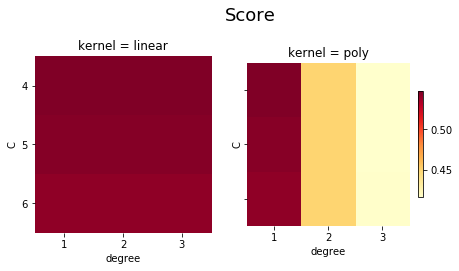

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 0.5468415721920198


In [0]:
from sklearn.model_selection import ParameterGrid
# from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
import parfit.parfit as pf


grid = {
    # 'alpha': [0.0001], # learning rate
    # # 'n_iter': [1000], # number of epochs
    # 'max_iter': [50,80,1000],
    # 'loss': ['hinge','modified_huber','squared_loss'], # logistic regression,
    # 'penalty': ('l2', 'elasticnet'),
    # 'n_jobs': [-1]
    'kernel':('linear','poly',),
    'gamma':('scale',),
    'degree':(1,2,3),
    'C':(4,5,6),
    
}

paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SVC, paramGrid,X_train, y_train, X_val, y_val, metric=multiclass_f1)

print(bestModel, bestScore)


In [0]:
svc = SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

svc.fit(train_tfidf, df["sentiment"])

y_pred_test = svc.predict(test_tfidf)

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_svm_partfit.csv",index=False)

### SVC -- pipeline gridsearch


In [0]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA


import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [0]:



pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
    # ('xg', XGBClassifier(random_state=42))
])

parameters = {
    'vect__max_df': (0.55,0.67),
    # 'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1,2),(1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__random_state':(1,42),
    # 'clf__max_iter': (20,10,80),
    'clf__C': (0.01,1),
    'clf__kernel' : ('linear','rbf'),
    'clf__degree' : (2,3),
    'clf__gamma' : ('scale','auto')
    # 'clf__penalty': ('l2','l1', 'elasticnet'),
    # 'clf__max_iter': (50, 55),
}

# C=1.0, cache_size=200, class_weight=None,
# coef0=0.0, decision_function_shape='ovr',
# degree=3, gamma='auto_deprecated',
# kernel='linear'

grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
# grid_search.fit(total_df.tweet.iloc[:7274], df["sentiment"])
grid_search.fit(total_df.tweet.iloc[:7149], df["sentiment"])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):

  print("\t%s: %r" % (param_name, best_parameters[param_name]))





Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': (0.01, 1),
 'clf__degree': (2, 3),
 'clf__gamma': ('scale', 'auto'),
 'clf__kernel': ('linear', 'rbf'),
 'clf__random_state': (1, 42),
 'vect__max_df': (0.55, 0.67),
 'vect__ngram_range': ((1, 2), (1, 2))}
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 36.2min finished


done in 2181.024s

Best score: 0.691
Best parameters set:
	clf__C: 1
	clf__degree: 2
	clf__gamma: 'scale'
	clf__kernel: 'linear'
	clf__random_state: 1
	vect__max_df: 0.55
	vect__ngram_range: (1, 2)


In [0]:
# Best score: 0.691
# Best parameters set:
# 	clf__C: 1
# 	clf__degree: 2
# 	clf__gamma: 'scale'
# 	clf__kernel: 'linear'
# 	clf__random_state: 1
# 	vect__max_df: 0.55
# 	vect__ngram_range: (1, 2)

from sklearn.decomposition import TruncatedSVD
vec = CountVectorizer(max_df=0.50,ngram_range= (1,2))
train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7149])
test_df_vec = vec.transform(total_df.tweet.iloc[7149:])

tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)

train_tfidf = train_tfidf
test_tfidf = test_tfidf



In [0]:
from sklearn.svm import SVC
svm = SVC(kernel='linear',gamma='scale',degree=2,C=1,random_state=42,verbose=1)
svm.fit(train_tfidf, df["sentiment"])
y_pred_test = svm.predict(test_tfidf)

# print(pd.Series(y_pred_test).value_counts())

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_svcgrid__pca1.csv",index=False)

[LibSVM]

### Light GBM

In [0]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier


In [0]:
clf_LGBM = lgbm.LGBMClassifier(objective='multiclass', verbose=-1, learning_rate=0.5, max_depth=20, num_leaves=50, n_estimators=120, max_bin=2000,)
clf_LGBM.fit(train_tfidf, df["sentiment"])
predicted_LGBM = clf_LGBM.predict(test_tfidf)

In [0]:
print(pd.Series(predicted_LGBM).value_counts())


1    1249
2     507
0      63
dtype: int64


In [0]:
submit_id=list(df_test["tweet_id"])
submit_pred=list(predicted_LGBM)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_lgbm_rm3.csv",index=False)


### SGD - F1 SCORE 67

In [0]:
vec = CountVectorizer(max_df=0.5,ngram_range= (1,2))
train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7274])
test_df_vec = vec.transform(total_df.tweet.iloc[7274:])

tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)


In [0]:
train_tfidf.shape, test_tfidf.shape

((7274, 34709), (1819, 34709))

In [0]:
sgd = SGDClassifier(alpha=1e-05,max_iter=10,penalty= 'elasticnet', random_state=1)
sgd.fit(train_tfidf, df["sentiment"])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=10,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
y_pred_test = sgd.predict(test_tfidf)

In [0]:
# 1    1116
# 2     613
# 0      82
# 3       8

print(pd.Series(y_pred_test).value_counts())

1    1124
2     620
0      66
3       9
dtype: int64


In [0]:
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_rstate1_duplicate1.csv",index=False)


### Random Forest

In [0]:


grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

parameters = {
    'vect__max_df': (0.5,0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_depth':(10,20,50),
    'clf__max_features':(10,20)
}

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(total_df.tweet.iloc[:7274], df["sentiment"])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__max_depth': (10, 20, 50),
 'clf__max_features': (10, 20),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   27.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 27.654s

Best score: 0.614
Best parameters set:
	clf__max_depth: 50
	clf__max_features: 20
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)


### NB

In [0]:
grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1)

from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
    # ('xg', XGBClassifier(random_state=42))
])

parameters = {
    'vect__max_df': (0.5,0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
   
    'clf__alpha': (0.01,0.001,1),
    
}

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(total_df.tweet.iloc[:7274], df["sentiment"])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):

  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.01, 0.001, 1),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.7s


done in 10.177s

Best score: 0.648
Best parameters set:
	clf__alpha: 1
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.9s finished


In [0]:
vec = CountVectorizer(max_df=0.75,ngram_range= (1,2))
train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7274])
test_df_vec = vec.transform(total_df.tweet.iloc[7274:])

tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)

nb = MultinomialNB(alpha=1e-05)
nb.fit(train_tfidf, df["sentiment"])
y_pred_test = nb.predict(test_tfidf)

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_nb_param.csv",index=False)

# Topic Modelling

In [0]:
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [157]:
total_df.shape,df.shape 

((8968, 1), (7149, 3))

In [0]:
train_df = total_df.iloc[:7149]

In [159]:
train_df.head()

,tweet
0,define language touch different dialect become...
1,learn doodle doodle light funny innovative exc...
2,one face steal show yrs school mkt expe
3,would pretty awesome crash every min extend br...
4,line outside wait


In [0]:
df1= train_df.tweet.copy()

In [163]:
df1.head()

0    define language touch different dialect become...
1    learn doodle doodle light funny innovative exc...
2              one face steal show yrs school mkt expe
3    would pretty awesome crash every min extend br...
4                                    line outside wait
Name: tweet, dtype: object

In [0]:
data = df1 #train_df.tweet
data = data.apply(lambda x: x.split()) # cleaned doc
id2word = corpora.Dictionary(data) # dictonary

In [0]:
corpus = [id2word.doc2bow(text) for text in data] # doctermmatrix

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [167]:
pprint(lda_model.print_topics())

[(0,
  '0.033*"pop" + 0.026*"open" + 0.023*"android" + 0.019*"via" + 0.019*"mobile" '
  '+ 0.018*"win" + 0.017*"see" + 0.016*"come" + 0.013*"make" + '
  '0.012*"temporary"'),
 (1,
  '0.017*"good" + 0.017*"great" + 0.014*"time" + 0.012*"week" + 0.011*"video" '
  '+ 0.010*"session" + 0.008*"detail" + 0.008*"facebook" + 0.008*"live" + '
  '0.007*"y"'),
 (2,
  '0.019*"free" + 0.018*"go" + 0.016*"tech" + 0.015*"people" + 0.015*"day" + '
  '0.014*"last" + 0.013*"year" + 0.013*"use" + 0.012*"cool" + 0.011*"design"'),
 (3,
  '0.047*"circle" + 0.045*"social" + 0.034*"network" + 0.033*"today" + '
  '0.027*"line" + 0.023*"call" + 0.021*"major" + 0.016*"possibly" + '
  '0.016*"show" + 0.015*"one"')]


#### Cohorence score to find the optimal number of topics

In [168]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

  """
  Compute c_v coherence for various number of topics

  Parameters:
  ----------
  dictionary : Gensim dictionary
  corpus : Gensim corpus
  texts : List of input texts
  limit : Max num of topics

  Returns:
  -------
  model_list : List of LDA topic models
  coherence_values : Coherence values corresponding to the LDA model with respective number of topics
  """
  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
    print("num_topics",str(num_topics))
    Lda = gensim.models.ldamodel.LdaModel
    model = Lda(corpus, num_topics, id2word = dictionary, passes=50)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

  return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=55, step=2)

num_topics 2
num_topics 4
num_topics 6
num_topics 8
num_topics 10
num_topics 12
num_topics 14
num_topics 16
num_topics 18
num_topics 20
num_topics 22
num_topics 24
num_topics 26
num_topics 28
num_topics 30
num_topics 32
num_topics 34
num_topics 36
num_topics 38
num_topics 40
num_topics 42
num_topics 44
num_topics 46
num_topics 48
num_topics 50
num_topics 52
num_topics 54


In [169]:
len(coherence_values)

27

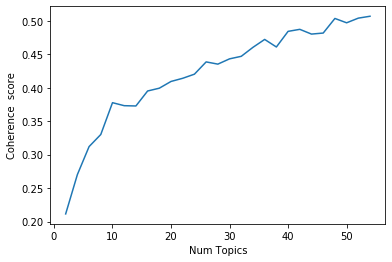

In [170]:

start=2; limit=55; step=2;
x = range(start, limit, step)

plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence  score")
plt.show()

First low point occurs around 20 topics so we select 15 topics to generate for the given data

In [171]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2113
Num Topics = 4  has Coherence Value of 0.2702
Num Topics = 6  has Coherence Value of 0.312
Num Topics = 8  has Coherence Value of 0.3302
Num Topics = 10  has Coherence Value of 0.3777
Num Topics = 12  has Coherence Value of 0.3733
Num Topics = 14  has Coherence Value of 0.3728
Num Topics = 16  has Coherence Value of 0.3952
Num Topics = 18  has Coherence Value of 0.3994
Num Topics = 20  has Coherence Value of 0.4095
Num Topics = 22  has Coherence Value of 0.4142
Num Topics = 24  has Coherence Value of 0.4204
Num Topics = 26  has Coherence Value of 0.4388
Num Topics = 28  has Coherence Value of 0.4354
Num Topics = 30  has Coherence Value of 0.4433
Num Topics = 32  has Coherence Value of 0.4471
Num Topics = 34  has Coherence Value of 0.4605
Num Topics = 36  has Coherence Value of 0.4724
Num Topics = 38  has Coherence Value of 0.4611
Num Topics = 40  has Coherence Value of 0.4844
Num Topics = 42  has Coherence Value of 0.4875
Num Topics = 44  h

### Finding Dominant Topic

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [0]:
# lda model selecting 4 topics for efficency

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [173]:
lda_model.per_word_topics

True

In [0]:
def format_topics_sentences(lda_model=None, corpus=corpus, texts=data):
  sent_topics_df = pd.DataFrame()

  for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list

    # print(row)
    # break

    row = sorted(row, key=lambda x: (x[1]),reverse=True)
    # print(row)
    for j, (topic_num, prop_topic) in enumerate(row):

      if j == 0: # a dominant topic
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word,prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
        break

  sent_topics_df.columns = ["Dominant_Topic", "%Contribution", "Topic_Keywords"]
  contents = pd.Series(texts)
  sent_topics_df=pd.concat([sent_topics_df,contents],1)
  return (sent_topics_df)
    

In [0]:
data.tail()

7269    [plze, tammi, middle, craziness, everything, s...
7270                 [set, edchat, musedchat, newtwitter]
7271    [aha, find, proof, lactation, room, excuse, mo...
7272                       [detail, first, edition, free]
7273    [next, fin, serv, battle, goog, mobile, operat...
Name: tweet, dtype: object

In [0]:
# format_topics_sentences(lda_model=lda_model,corpus=corpus,texts= data.tail())

In [0]:
df_topic_sents_keywords = format_topics_sentences(lda_model=lda_model,corpus=corpus,texts= data)

In [0]:
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [178]:
df_dominant_topic.tail()

,index,Dominant_Topic,%Contribution,Topic_Keywords,tweet
7266,7269,NaN,NaN,NaN,"[plze, tammi, middle, craziness, everything, s..."
7267,7270,NaN,NaN,NaN,"[set, edchat, musedchat, newtwitter]"
7268,7271,NaN,NaN,NaN,"[aha, find, proof, lactation, room, excuse, mo..."
7269,7272,NaN,NaN,NaN,"[detail, first, edition, free]"
7270,7273,NaN,NaN,NaN,"[next, fin, serv, battle, goog, mobile, operat..."


In [179]:
df_dominant_topic[~df_dominant_topic.Topic_Keywords.isnull()].shape, data.shape

((7149, 5), (7149,))

In [0]:
df_dominant = df_dominant_topic[~df_dominant_topic.Topic_Keywords.isnull()]

In [182]:
df_dominant.head()

,index,Dominant_Topic,%Contribution,Topic_Keywords,tweet
0,0,1.0,0.4930,"good, great, time, week, video, session, detai...","[define, language, touch, different, dialect, ..."
1,1,1.0,0.7767,"good, great, time, week, video, session, detai...","[learn, doodle, doodle, light, funny, innovati..."
2,2,3.0,0.6029,"circle, social, network, today, line, call, ma...","[one, face, steal, show, yrs, school, mkt, expe]"
3,3,1.0,0.3759,"good, great, time, week, video, session, detai...","[would, pretty, awesome, crash, every, min, ex..."
4,4,3.0,0.5637,"circle, social, network, today, line, call, ma...","[line, outside, wait]"


### WordCloud - Dominant Topics

In [0]:
# len(mcolors.XKCD_COLORS.items())

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [0]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]

In [0]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0
                  )

In [0]:
topics = lda_model.show_topics(formatted=False)


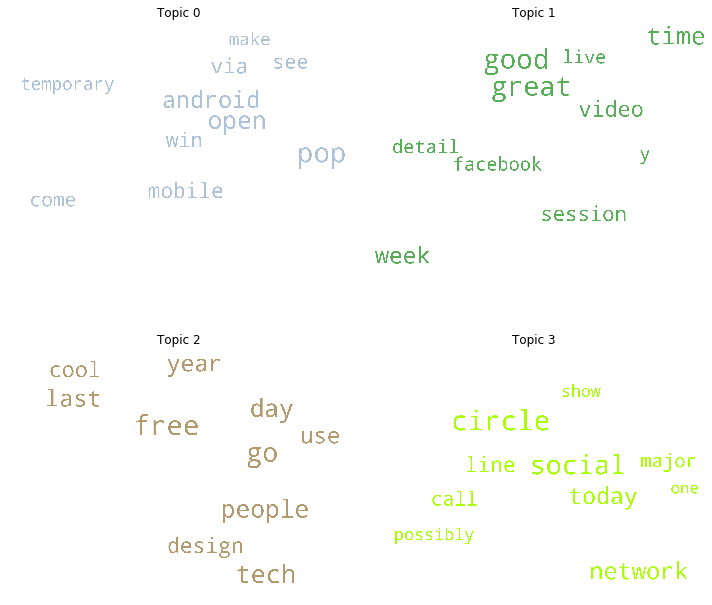

In [198]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  topic_words = dict(topics[i][1])
  cloud.generate_from_frequencies(topic_words, max_font_size=200)
  plt.gca().imshow(cloud)
  plt.gca().set_title("Topic "+str(i))
  plt.gca().axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0,y=0)
plt.tight_layout()
# plt.show()

### Visualizing the topics using t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding)

1. It is a non linear technique for dimentionality reduction visualizing high dimentional data 

2. It calculates the probability of similarity of points between high dimentional vs low dimentional data and it tries to minimize difference between probabilities of high dimentional vs low dimentional data.

In [0]:
from sklearn.manifold import TSNE


In [229]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
  topic_weights.append([w for i, w in row_list[0]])

mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.35]

topic_num = np.argmax(arr, axis=1)

tsne_model2d = TSNE(n_components=2, verbose=1, random_state=1, angle=.99, init='pca')
tsne_model3d = TSNE(n_components=3, verbose=1, random_state=1, angle=.99, init='pca')

tsne_lda2d = tsne_model2d.fit_transform(arr)
tsne_lda3d = tsne_model3d.fit_transform(arr)




[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6839 samples in 0.002s...
[t-SNE] Computed neighbors for 6839 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6839
[t-SNE] Computed conditional probabilities for sample 2000 / 6839
[t-SNE] Computed conditional probabilities for sample 3000 / 6839
[t-SNE] Computed conditional probabilities for sample 4000 / 6839
[t-SNE] Computed conditional probabilities for sample 5000 / 6839
[t-SNE] Computed conditional probabilities for sample 6000 / 6839
[t-SNE] Computed conditional probabilities for sample 6839 / 6839
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.326412
[t-SNE] KL divergence after 1000 iterations: 0.557980
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6839 samples in 0.002s...
[t-SNE] Computed neighbors for 6839 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6839
[t-SNE] Computed conditional 

In [0]:
# pd.Series(topic_num).value_counts()

##### 2d plot t-sne

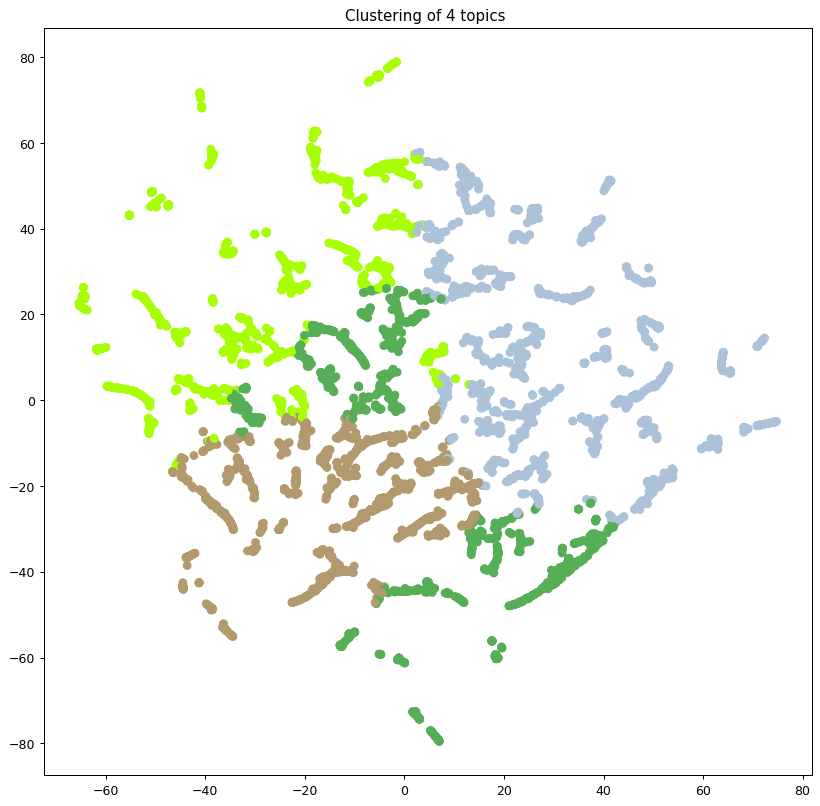

In [231]:

plt.figure(num=None, figsize=(11, 11), dpi=90, facecolor='w', edgecolor='k')
plt.scatter(x=tsne_lda2d[:,0], y=tsne_lda2d[:,1],color=mycolors[topic_num])
plt.title("Clustering of 4 topics ")
plt.show()

#### t-sne 2d plot in 3d axes

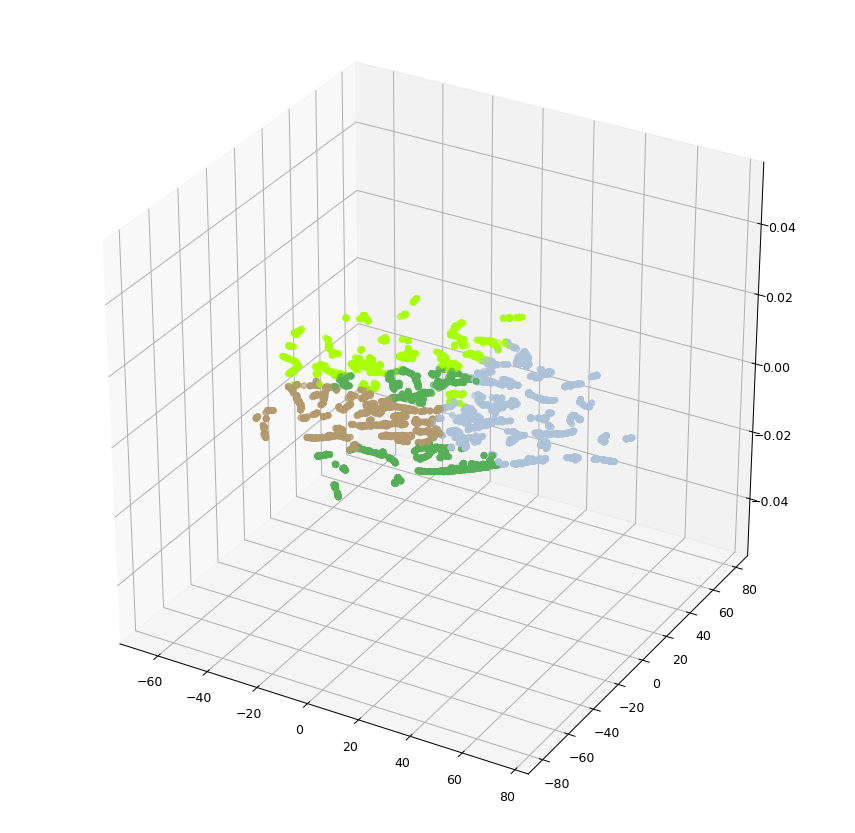

In [233]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

l1 = list(set(mycolors[topic_num].tolist()))

legend_dict  = dict(zip(["topic1","topic2", "topic3","topic4"],l1))

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne_lda2d), c=mycolors[topic_num], cmap='RdBu')


patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

# plt.legend(handles=patchList)
plt.show()

#### 3d plot of topics with t-sne

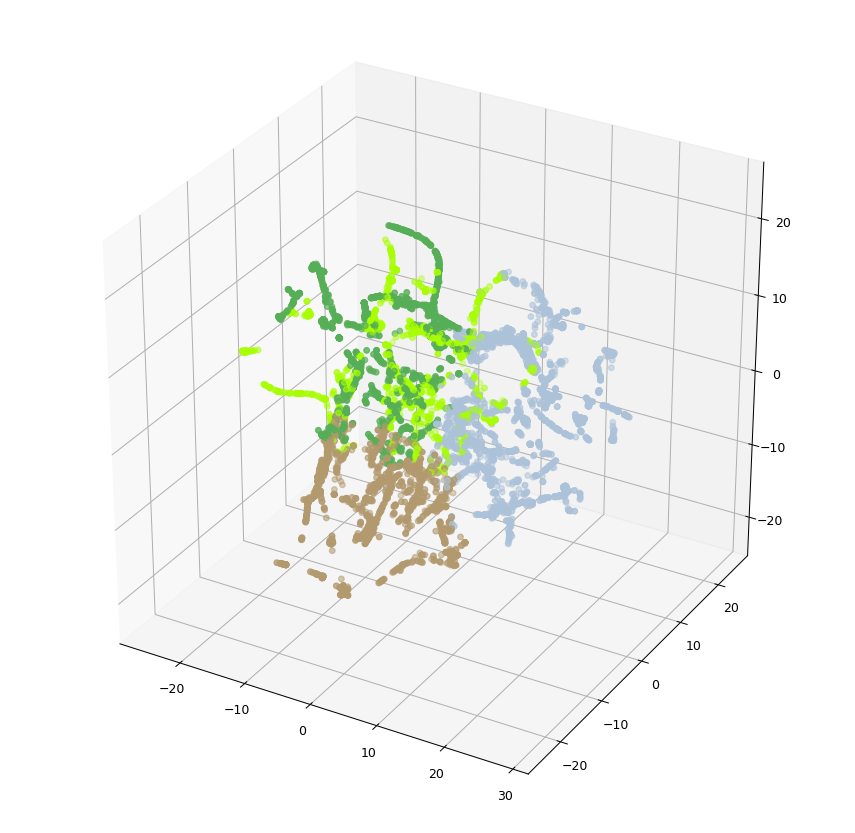

In [234]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

l1 = list(set(mycolors[topic_num].tolist()))

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne_lda3d), c=mycolors[topic_num], cmap='RdBu')


patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

plt.show()

#### t-SNE for 15 topics

In [0]:
lda_model_15topics = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [236]:
topic_weights = []
for i, row_list in enumerate(lda_model_15topics[corpus]):
  topic_weights.append([w for i, w in row_list[0]])

mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.35]

topic_num = np.argmax(arr, axis=1)

tsne_model = TSNE(n_components=3, verbose=1, random_state=1, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)




[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4335 samples in 0.003s...
[t-SNE] Computed neighbors for 4335 samples in 0.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4335
[t-SNE] Computed conditional probabilities for sample 2000 / 4335
[t-SNE] Computed conditional probabilities for sample 3000 / 4335
[t-SNE] Computed conditional probabilities for sample 4000 / 4335
[t-SNE] Computed conditional probabilities for sample 4335 / 4335
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.741505
[t-SNE] KL divergence after 1000 iterations: 0.409113


#### t-sne with 3 dimentions of 15 topics

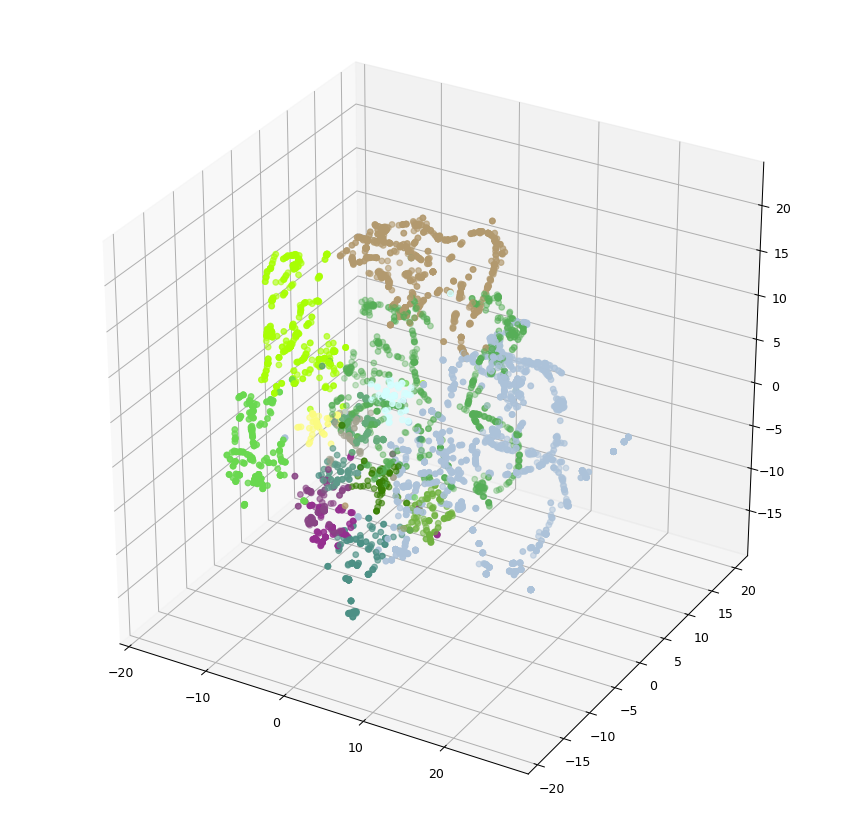

In [238]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

l1 = list(set(mycolors[topic_num].tolist()))

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne_lda), c=mycolors[topic_num], cmap='RdBu')


patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

plt.show()